In [1]:
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import learning_curve, validation_curve, cross_val_score, train_test_split, KFold, GridSearchCV

from plotting import Plotting
from cholesky import Cholesky

In [2]:
scoring = 'r2'
scoring_neg = False
scoring_label = 'R²'
scoring_label_loss = 'R²'

#scoring = 'neg_mean_squared_error'
#scoring_neg = True
#scoring_label = 'MSE'
#scoring_label_loss = 'Squared loss'

In [3]:
column_to_predict = 'median_house_value'
categories_columns = ['ocean_proximity']
numerics_columns = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]

In [4]:
data_frame = pandas.read_csv(filepath_or_buffer='cal-housing.csv')

In [5]:
for c in data_frame.columns:
    if data_frame[c].hasnans:
        m = data_frame[c].mean()
        data_frame[c].fillna(value=m, inplace=True)

In [6]:
useLabelEncoder = False
useColumnCat = False

if useLabelEncoder:
    labelencoder = LabelEncoder()

    for c in categories_columns:
        c_name = c + '_cat'
        data_frame[c_name] = labelencoder.fit_transform(data_frame[c])
        numerics_columns.append(c_name)

    data_frame.drop(columns=categories_columns, inplace=True)
elif useColumnCat:
    # genera le colonne per ogni elemento di una colonna categoria
    columns_categories = pandas.DataFrame()

    for c in categories_columns:
        column = pandas.get_dummies(data=data_frame[c], prefix=c + '_')        
        columns_categories = pandas.concat((columns_categories, column), axis=1)

    for col in columns_categories.columns: 
        numerics_columns.append(col)
        
    # elimina le colonne categoria
    data_frame.drop(columns=categories_columns, inplace=True)

    # aggiungi le colonne per ogni elemento di una colonna categoria
    data_frame = pandas.concat([data_frame, columns_categories], axis=1)
else:
    data_frame['ocean_proximity'].replace(['INLAND', '<1H OCEAN', 'NEAR OCEAN', 'ISLAND', 'NEAR BAY'], [1, 20, 100, 1500, 500], inplace=True)
    numerics_columns.append('ocean_proximity')

In [7]:
columns_to_remove = []
columns_to_use = list(data_frame.columns)

for u in columns_to_remove:
    columns_to_use.remove(u)
    if numerics_columns.count(u) > 0:
        numerics_columns.remove(u)
        
data_frame.drop(columns=columns_to_remove, inplace=True)
#data_frame = data_frame.sample(frac=1)

X = data_frame[numerics_columns]
y = data_frame[column_to_predict]

Quindi la nostra attuale X è la seguente:

In [8]:
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,500
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,500
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,500
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,500
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,500
...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,1
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,1
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,1
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,1


Quindi la nostra attuale y è la seguente:

In [9]:
y

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64

In [10]:
column_to_predict_idx = data_frame.columns.get_loc(column_to_predict)
cols = list(range(0, data_frame.shape[1]))
cols.remove(column_to_predict_idx)

#scaler = MinMaxScaler()
#scaler = RobustScaler()
#scaler = StandardScaler()
#scaler = Normalizer()

#scaler.fit(data_frame)
#data_frame = scaler.transform(data_frame)
#data_frame = pandas.DataFrame(data_frame, columns=columns_to_use)

X = data_frame[numerics_columns]
y = data_frame[column_to_predict]

In [11]:
X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,500
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,500
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,500
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,500
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,500
...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,1
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,1
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,1
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,1


In [12]:
y

0        452600.0
1        358500.0
2        352100.0
3        341300.0
4        342200.0
           ...   
20635     78100.0
20636     77100.0
20637     92300.0
20638     84700.0
20639     89400.0
Name: median_house_value, Length: 20640, dtype: float64

In [13]:
alphas = numpy.sort(numpy.linspace(1, 0, 10, False))
alphas

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [14]:
cholesky = Cholesky()

### Validation curve
Determine training and test scores for varying parameter values.

Compute scores for an estimator with different values of a specified parameter. This is similar to grid search with one parameter. However, this will also compute training scores and is merely a utility for plotting the results.

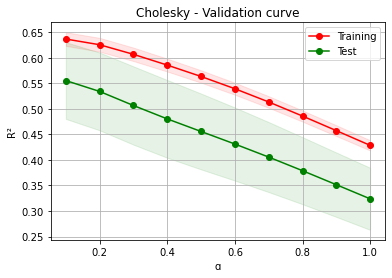

Best ɑ: 0.09999999999999998


In [15]:
train_score, test_scores = validation_curve(cholesky, X, y, param_name="alpha", param_range=alphas, scoring=scoring, n_jobs=-1)

Plotting.plotAreaMeanStd(
    'Cholesky - Validation curve',
    alphas,
    [train_score, test_scores],
    scoring_neg,
    ['Training', 'Test'],
    ['r', 'g'],
    'ɑ',
    scoring_label_loss)

print('Best ɑ:', alphas[numpy.argmax(numpy.mean(test_scores, axis=1))])

### Learning curve
Determines cross-validated training and test scores for different training set sizes.

A cross-validation generator splits the whole dataset k times in training and test data. Subsets of the training set with varying sizes will be used to train the estimator and a score for each training subset size and the test set will be computed. Afterwards, the scores will be averaged over all k runs for each training subset size.

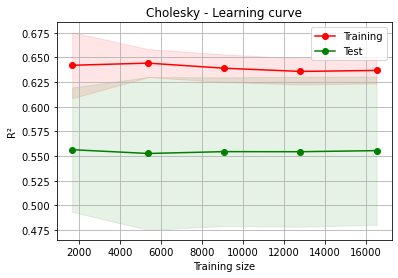

In [16]:
cholesky.alpha = 0.1
train_size, train_score, test_scores = learning_curve(cholesky, X, y, shuffle=True, scoring=scoring, n_jobs=-1)

Plotting.plotAreaMeanStd(
    'Cholesky - Learning curve',
    train_size,
    [train_score, test_scores],
    scoring_neg,
    ['Training', 'Test'],
    ['r', 'g'],
    'Training size',
    scoring_label_loss)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [18]:
cholesky.calculateScoring(alphas, x_train, y_train, x_test, y_test)
cholesky.printBestScores()

Cholesky:
-best ɑ: 0.09999999999999998
-best MSE: 4685714927.600992
-best R²: 0.6364981311428053


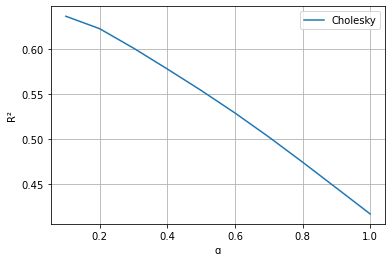

In [19]:
Plotting.plotXY(alphas, [cholesky.R2], [cholesky.algo], 'ɑ', 'R²')

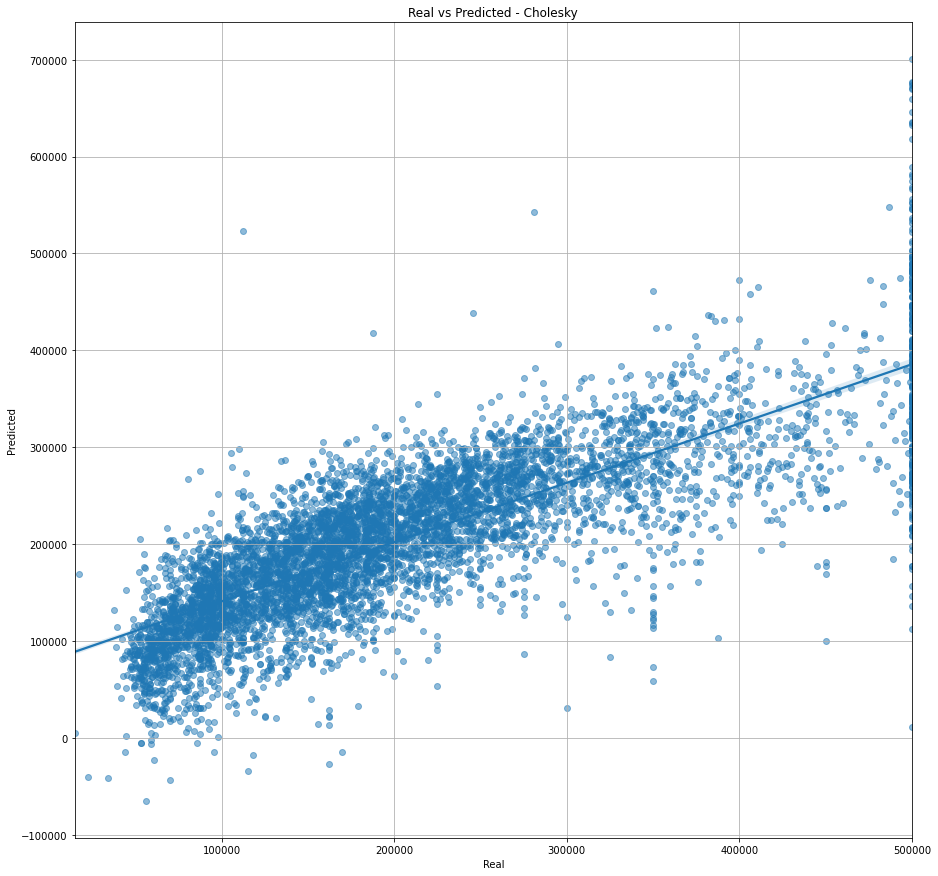

In [20]:
cholesky.fit(x_train, y_train)
y_predict_c = cholesky.predict(x_test)
Plotting.regPlot('Cholesky', y_predict_c, y_test)